# Semantic Segmentation of car images

In this notebook, we will design a semantic segmentation model using the CamVid dataset

## Setup

The following cells will import important packages, configure devices, load TensorBoard etc

In [16]:
import sys
import numpy as np
import os
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

In [17]:
# Set up device

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"device being used: {device}")


device being used: cpu


In [18]:
# Set up Matplotlib

plt.rcParams["figure.figsize"] = (10.0, 8.0)  # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"


In [19]:
# Some small fixes to prevent Jupyter from bugging out

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

# To prevent the kernel from dying.
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
# Set up TensorBoard

""" Timm notes on superbuggy tensorboard

For some reason tensorboard isn't quitting properly, and keeps the port occupied even
if the process itself is killed.

1. Check Code Python Interpreter is i2dl

2. Check if port occupied:
lsof -i:6006

Kill using the PID from above command (not 6006, the PID!):
kill PID

See https://stackoverflow.com/questions/54395201/tensorboard-could-not-bind-to-port-6006-it-was-already-in-use
Also, see this on how to kill tensorboard process (but not the problem here): https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server

3. Alternative if I want to see tensorboard in a webbrowser:
tensorboard --logdir=data/ --host localhost --port 8888
http//localhost:8888

"""

# %load_ext tensorboard
# %reload_ext tensorboard
# %tensorboard --logdir lightning_logs --port 6006


" Timm notes on superbuggy tensorboard\n\nFor some reason tensorboard isn't quitting properly, and keeps the port occupied even\nif the process itself is killed.\n\n1. Check Code Python Interpreter is i2dl\n\n2. Check if port occupied:\nlsof -i:6006\n\nKill using the PID from above command (not 6006, the PID!):\nkill PID\n\nSee https://stackoverflow.com/questions/54395201/tensorboard-could-not-bind-to-port-6006-it-was-already-in-use\nAlso, see this on how to kill tensorboard process (but not the problem here): https://stackoverflow.com/questions/36896164/tensorflow-how-to-close-tensorboard-server\n\n3. Alternative if I want to see tensorboard in a webbrowser:\ntensorboard --logdir=data/ --host localhost --port 8888\nhttp//localhost:8888\n\n"

# Download and prepare dataset

## CityScape Dataset

The CityScape dataset will not download automatically with Torchvision. Instead, you will have to download it from their [website](https://www.cityscapes-dataset.com/) by signing up and downloading the *gtFine* and *leftImg8bit* datasets, and placing them in ```root/data/cityscapes``` folder in the root directory of this repository.

Sadly, the CityScapes Class in Torchvision does not seem to accept slice indexes, so we will have to write our own little version on top of it which fixes the ```__getitem__``` method. That way, we can do something like ```train_dataset[0:3]``` and not just ```train_dataset[1]```

Also, applying our model on the full resolution images would be very long, so we will reduce the image resolution for both input and output images

In [21]:
from typing import Any, Callable, Dict, List, Optional, Tuple, Union
from torchvision.datasets import Cityscapes
from PIL.Image import Resampling

""" TODO: 
- Type annotations would be really nice here
- Image resolution too high: need to downsize and upsample probably
"""

SCALING_FACTOR = 8


class FixedCityScapes(Cityscapes):
    def __init__(
        self,
        root: str,
        split: str = "train",
        mode: str = "fine",
        target_type: List[str] | str = "instance",
        transform: Callable[..., Any] | None = None,
        target_transform: Callable[..., Any] | None = None,
        transforms: Callable[..., Any] | None = None,
    ) -> None:
        super().__init__(
            root, split, mode, target_type, transform, target_transform, transforms
        )

        # TODO: Maybe check if multiple of 2?
        self.scaled_w: int = 2048 // SCALING_FACTOR
        self.scaled_h: int = 1024 // SCALING_FACTOR

    def __getitem__(self, key) -> Tuple[Any, Any]:
        if isinstance(key, slice):
            # This will take the start, stop and step of the slice
            # self[i] will return the below isinstance(key, int) logic
            return [self[i] for i in range(*key.indices(len(self)))]
        elif isinstance(key, int):
            raw = super().__getitem__(key)
            data = (
                raw[0].resize((self.scaled_w, self.scaled_h), Resampling.NEAREST),
                (
                    raw[1][0].resize(
                        (self.scaled_w, self.scaled_h), Resampling.NEAREST
                    ),
                    raw[1][1].resize(
                        (self.scaled_w, self.scaled_h), Resampling.NEAREST
                    ),
                ),
            )
            return data
        else:
            raise TypeError(f"Invalid argument type (key is of type {type(key)})")

In [22]:
from torchvision.datasets import Cityscapes

# https://pytorch.org/vision/0.15/generated/torchvision.datasets.Cityscapes.html#torchvision.datasets.Cityscapes
# https://stackoverflow.com/questions/56650201/how-to-convert-35-classes-of-cityscapes-dataset-to-19-classes
# https://www.cityscapes-dataset.com/downloads/

# TODO: Augmentations and transforms

print("Loading training dataset")
train_dataset = FixedCityScapes(
    root="data/cityscapes",
    split="train",
    mode="fine",
    target_type=["semantic", "color"],
)
print("Loading validation dataset")
val_dataset = FixedCityScapes(
    root="data/cityscapes", split="val", mode="fine", target_type=["semantic", "color"]
)
print("Loading test dataset")
test_dataset = FixedCityScapes(
    root="data/cityscapes", split="test", mode="fine", target_type="semantic"
)  # Test data is unlabeled, so semantic target is simply black
print("Done loading datasets")

Loading training dataset
Loading validation dataset
Loading test dataset
Done loading datasets


In [23]:
# Show some basic information about the dataset

print("Train size: %i" % len(train_dataset))
print("Validation size: %i" % len(val_dataset))
print("Test size: %i" % len(test_dataset))

# Dataset returns a tuple of PIL Images, input image and segmented groundtruth
# https://pillow.readthedocs.io/en/stable/reference/Image.html#image-attributes
first_image = train_dataset[0]
print(f"Image dimensions: {first_image[0].size}")
print(f"Segmentation mask dimensions: {first_image[1][0].size}")
print(
    f"Target tuple size: {len(first_image[1])}"
)  # items called from the dataset are a tuple, first item is input image, second is another tuple with targets

# first_image[0].show() # Opens image in a new window, so don't use

Train size: 2975
Validation size: 500
Test size: 1525
Image dimensions: (256, 128)
Segmentation mask dimensions: (256, 128)
Target tuple size: 2


In [24]:
# Function to visualize data

from PIL.Image import Image

# TODO: Clean up repeated code


def visualize_imgs(images):
    if isinstance(images[0], Image):
        plt.figure(figsize=(20, 6))

        # Input image
        plt.subplot(1, 3, 1)
        plt.imshow(images[0])
        plt.axis("off")
        plt.title("Input image")

        # Colored Ground truth segmented image
        # Input image
        plt.subplot(1, 3, 2)
        plt.imshow(images[1][1])
        plt.axis("off")
        plt.title("Ground Truth Segmentation (colored)")

        # Ground truth using ids (so basically shades of grey)
        # Input image
        plt.subplot(1, 3, 3)
        plt.imshow(images[1][0])
        plt.axis("off")
        plt.title("Ground Truth Segmentation (ids)")
    else:
        n = len(images)
        plt.figure(figsize=(20, 6 * n))
        for i, (img, target) in enumerate(images):
            # Input image
            plt.subplot(n, 3, i * 3 + 1)
            plt.imshow(img)
            plt.axis("off")
            if i == 0:
                plt.title("Input image")

            # Colored Ground truth segmented image
            # Input image
            plt.subplot(n, 3, i * 3 + 2)
            plt.imshow(target[1])
            plt.axis("off")
            if i == 0:
                plt.title("Ground Truth (colored)")

            # Ground truth using ids (so basically shades of grey)
            # Input image
            plt.subplot(n, 3, i * 3 + 3)
            plt.imshow(target[0])
            plt.axis("off")
            if i == 0:
                plt.title("Ground Truth Segmentation (IDs)")

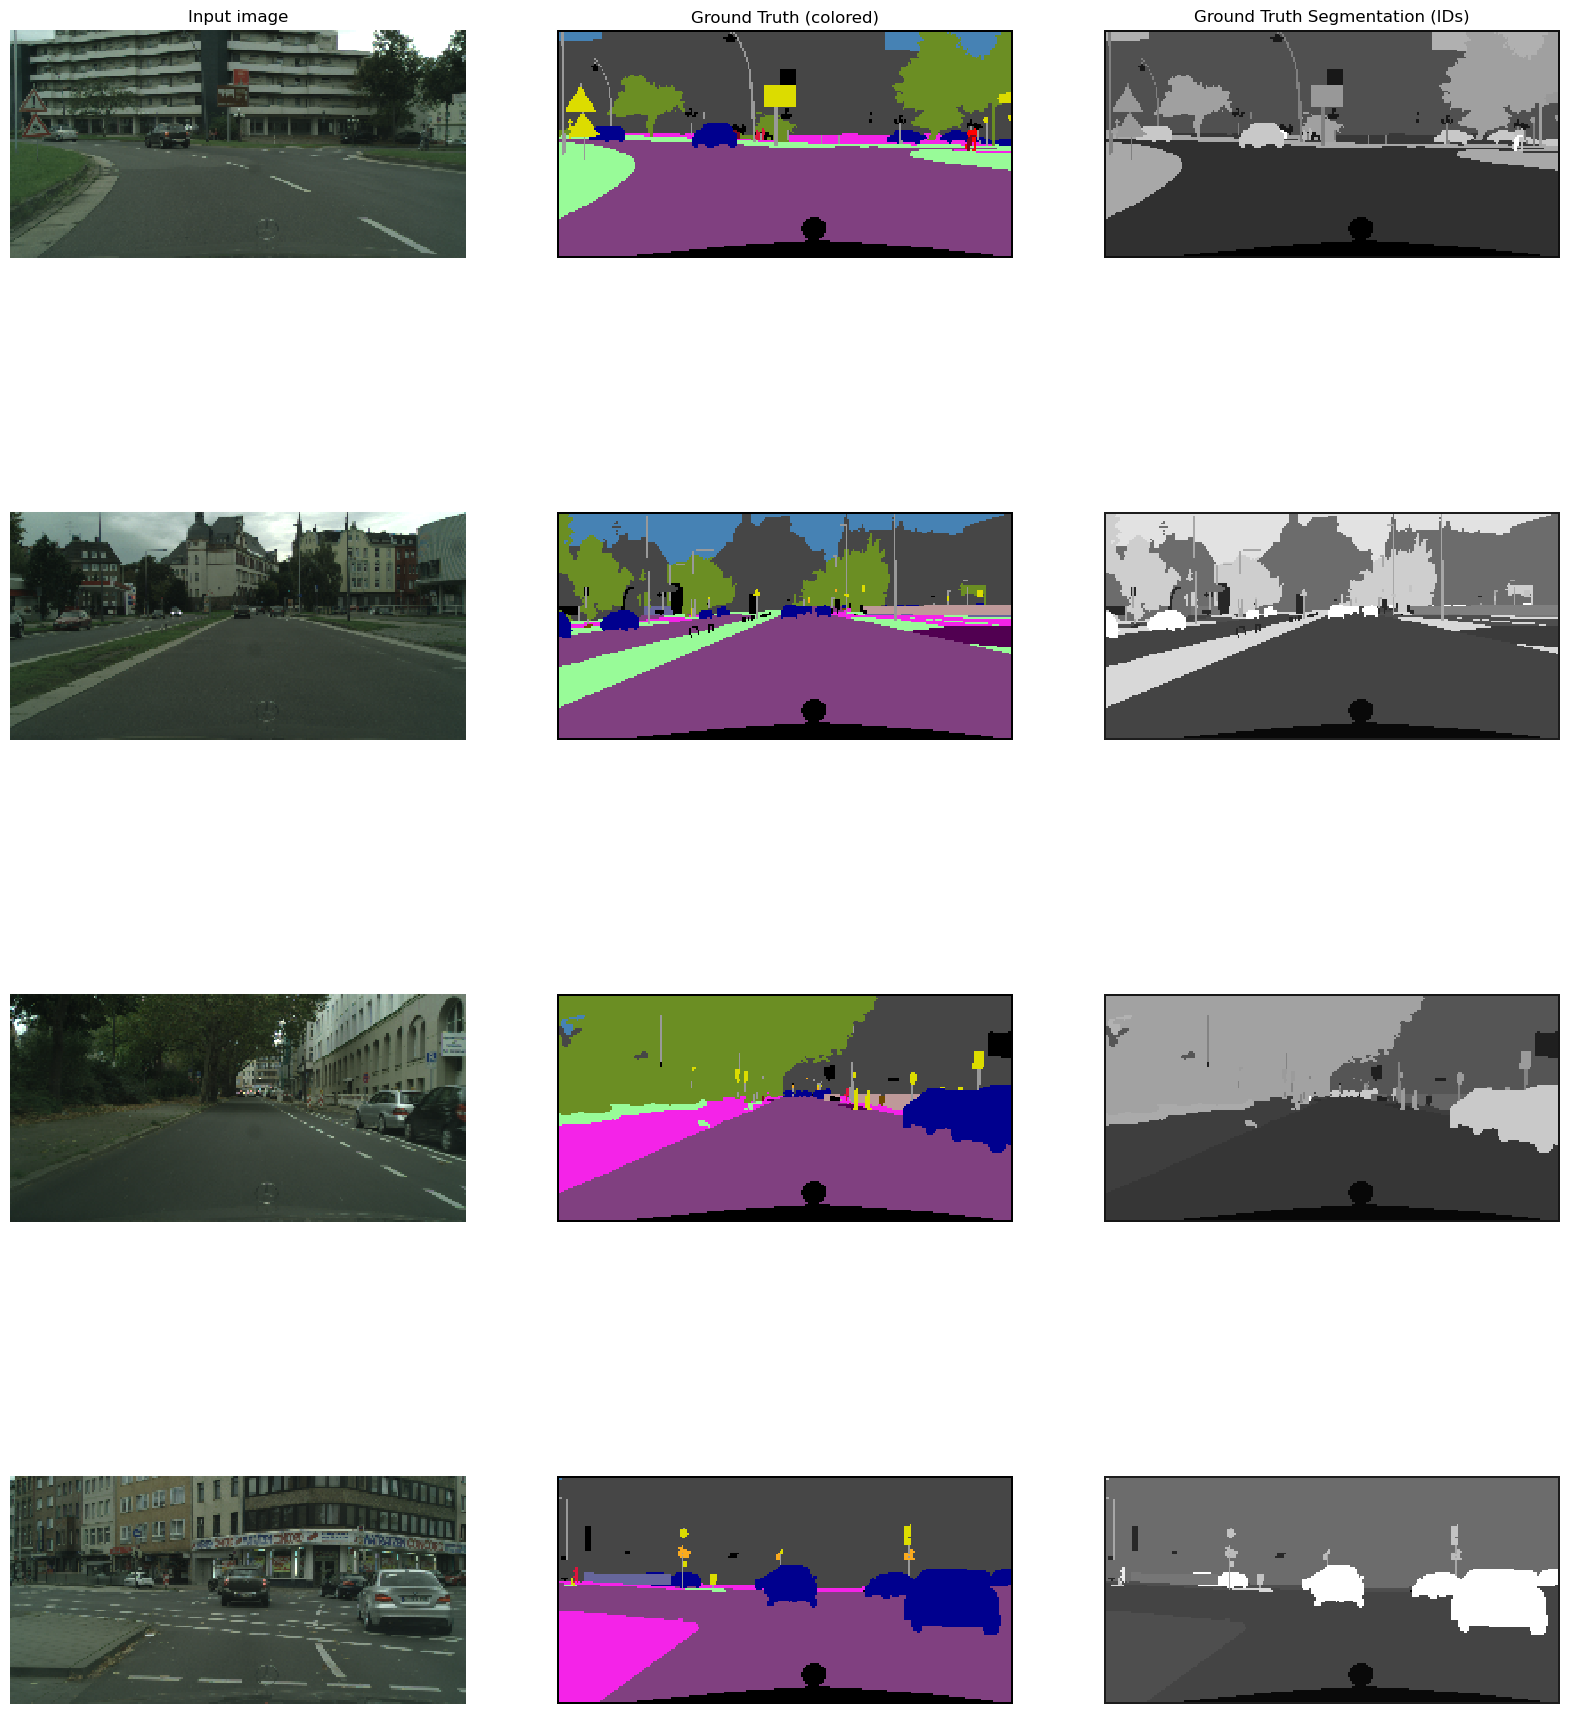

In [25]:
# Show some of the dataset

num_example_imgs = 4
visualize_imgs(train_dataset[0:num_example_imgs])


TODO:

- Create model
- Create tensor that uses one hot encoding for ids, not just a flat image
- Use a UNet
- Create trainer (use dataloader, load to device)
- Use a good loss function

# Design of Segmentation Model

In [26]:
# Helper Classes


class ConvSandwich(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1, padding=1):
        super(ConvSandwich, self).__init__()
        self.conv = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, bias=False
        )  # Because we use Batchnorm, bias is averaged out
        self.norm = nn.BatchNorm2d(out_channels)
        self.activation = nn.ReLU()

    def forward(self, x):
        x = self.conv(x)
        x = self.norm(x)
        x = self.activation(x)
        return x


class PrintLayer(nn.Module):
    def forward(self, x):
        print(x.shape)
        return x

In [34]:
# Encoder and Decoder

"""
TODO:
- Optimizer only train encoder of decoder
- Make my own model
- Use PyTorch optimizations from their guide: 
"""


class SegmentationNN(nn.Module):
    def __init__(self, hp={}):
        super().__init__()
        self.hp = hp

        self.mid_channels = 64
        self.pre_process = ConvSandwich(3, self.mid_channels, 3, 1, 1)
        self.encoder_block = nn.ModuleList(
            [
                ConvSandwich(self.mid_channels, self.mid_channels * 2, 3, 1, 1),
                ConvSandwich(self.mid_channels * 2, self.mid_channels * 4, 3, 1, 1),
                ConvSandwich(self.mid_channels * 4, self.mid_channels * 4, 3, 1, 1),
                ConvSandwich(self.mid_channels * 4, self.mid_channels * 8, 3, 1, 1),
            ]
        )

        self.decoder_block = nn.ModuleList(
            [
                ConvSandwich(
                    self.mid_channels * (8 + 8), self.mid_channels * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.mid_channels * (4 + 4), self.mid_channels * 4, 3, 1, 1
                ),
                ConvSandwich(
                    self.mid_channels * (4 + 4), self.mid_channels * 2, 3, 1, 1
                ),
                ConvSandwich(self.mid_channels * (2 + 2), self.mid_channels, 3, 1, 1),
            ]
        )

        self.downsample = nn.MaxPool2d(kernel_size=2, stride=2)
        self.upsample = nn.Upsample(scale_factor=2, mode="bicubic")
        self.classifier = nn.Conv2d(
            self.mid_channels * 2 + 3, self.hp["output_size"], kernel_size=3, padding=1
        )
        self.print = PrintLayer() # Used for debugging
        
        self.set_optimizer()
        
        # TODO: Weights init

    def forward(self, x):
        # Unet network

        # Note to self: need to use multiples of 2 or else rounding makes torch.cat try to concat tensors
        # of different sizes

        proc_x = self.pre_process(x)
        enc_1 = self.encoder_block[0](proc_x)
        tmp = self.downsample(enc_1)
        enc_2 = self.encoder_block[1](tmp)
        tmp = self.downsample(enc_2)
        enc_3 = self.encoder_block[2](tmp)
        tmp = self.downsample(enc_3)
        enc_4 = self.encoder_block[3](tmp)

        bottleneck = self.downsample(enc_4)

        tmp = self.upsample(bottleneck)
        dec_1 = self.decoder_block[0](torch.cat([tmp, enc_4], dim=1))
        tmp = self.upsample(dec_1)
        dec_2 = self.decoder_block[1](torch.cat([tmp, enc_3], dim=1))
        tmp = self.upsample(dec_2)
        dec_3 = self.decoder_block[2](torch.cat([tmp, enc_2], dim=1))
        tmp = self.upsample(dec_3)
        dec_4 = self.decoder_block[3](torch.cat([tmp, enc_1], dim=1))
        tmp = self.upsample(dec_4)

        dec_4 = torch.cat([dec_4, proc_x], dim=1)
        dec_4 = torch.cat([dec_4, x], dim=1)
        x = self.classifier(dec_4)

        return x

    def set_optimizer(self):
        self.optimizer = None

        self.optimizer = torch.optim.Adam(
            self.parameters(),
            lr=self.hp["learning_rate"],
            weight_decay=self.hp["weight_decay"],
        )

    def training_step(self, batch, loss_func):
        self.train()

        self.optimizer.zero_grad()  # Reset gradient every batch

        # N = batch size, C = channels (3 for RGB), H = image height, W = image width
        images = batch[0].to(self.device)  # Input batch, N x C x H x W
        labels = batch[1][0].to(
            self.device
        )  # Ground truth, each pixel assigned an ID int. N x H x W

        # Model makes prediction (forward pass)
        pred = self.forward(images)

        # Calculate loss, do backward pass to update weights, optimizer takes step
        loss = loss_func(pred, labels)
        loss.backward()
        self.optimizer.step()

        return loss

    def validation_step(self, batch, loss_func):
        loss = 0

        # Set model to eval
        self.eval()

        with torch.no_grad():
            images = batch[0].to(self.device)  # Input batch, N x C x H x W
            labels = batch[1][0].to(
                self.device
            )  # Ground truth, each pixel assigned an ID int. N x H x W

            pred = self.forward(images)
            loss = loss_func(pred, labels)

    def save(self, path):
        print(f"Saving the model to {path}")
        torch.save(self, path)

# Train Model

In [28]:
# Hyperparameters

hparams = {
    "device": device,
    "num_workers": 8,
    "epochs": 10,
    "batch_size": 4,
    "max_patience": 10,
    "input_size": 256 * 128,  # Scaled image resolution
    # Classes in CityScape, should be 35
    "output_size": len(Cityscapes.classes),
    "learning_rate": 1e-3,
    "weight_decay": 1e-8,
}


Since this is just for demonstration purposes, let us make sure the model is not too big. We want to be able to run it on something like a CPU even if we don't have access to a GPU!

In [29]:
from torchinfo import summary

model = SegmentationNN(hp=hparams)
summary(model, input_size=(hparams["batch_size"], 3, 256, 128))


Layer (type:depth-idx)                   Output Shape              Param #
SegmentationNN                           [64, 35, 256, 128]        --
├─ConvSandwich: 1-1                      [64, 64, 256, 128]        --
│    └─Conv2d: 2-1                       [64, 64, 256, 128]        1,728
│    └─BatchNorm2d: 2-2                  [64, 64, 256, 128]        128
│    └─ReLU: 2-3                         [64, 64, 256, 128]        --
├─ModuleList: 1-8                        --                        (recursive)
│    └─ConvSandwich: 2-4                 [64, 128, 256, 128]       --
│    │    └─Conv2d: 3-1                  [64, 128, 256, 128]       73,728
│    │    └─BatchNorm2d: 3-2             [64, 128, 256, 128]       256
│    │    └─ReLU: 3-3                    [64, 128, 256, 128]       --
├─MaxPool2d: 1-3                         [64, 128, 128, 64]        --
├─ModuleList: 1-8                        --                        (recursive)
│    └─ConvSandwich: 2-5                 [64, 256, 128, 64

In [32]:
import torch
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


def create_tqdm_bar(iterable, desc):
    return tqdm(enumerate(iterable), total=len(iterable), ncols=150, desc=desc)

def train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=3, name='segmentation'):
    
    optimizer = model.optimizer
    
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=epochs * len(train_loader) / 5, gamma=0.7)
    
    validation_loss = 0
    model = model.to(device)
    
    patience = model.hp['max_patience']
    best_val_loss = 10e10
    
    for epoch in range(epochs):
        
        # Training
        training_loop = create_tqdm_bar(train_loader, desc=f'Training Epoch [{epoch + 1}/{epochs}]')
        training_loss = 0

In [35]:
model = SegmentationNN(hp=hparams)

# Create the tb_logger
path = os.path.join('logs', 'segmentation_logs')
num_of_runs = len(os.listdir(path)) if os.path.exists(path) else 0
path = os.path.join(path, f'run_{num_of_runs + 1}')
tb_logger = SummaryWriter(path)

# Train the model
# TODO: Maybe try to use a small dataset first?
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=hparams['batch_size'], shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=hparams['batch_size'], shuffle=False)

epochs = hparams.get('epochs', 5)
loss_func = torch.nn.CrossEntropyLoss(ignore_index=0, reduction='mean')
train_model(model, train_loader, val_loader, loss_func, tb_logger, epochs=epochs, name='segmentation')

Training Epoch [3/3]:   0%|                                                                                                    | 0/47 [00:00<?, ?it/s]
